In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchlensmaker as tlm

from xxchallenge import *

from torchlensmaker.core.transforms import TransformBase, TranslateTransform

from torchlensmaker.viewer.render_sequence import ForwardArtist
from torchlensmaker.elements.optical_surfaces import CollisionSurface
from torchlensmaker.core.physics import reflection

Tensor = torch.Tensor

class XZPlaneMirrorTransform(TransformBase):
    def direct_points(self, points: Tensor) -> Tensor:
        scale = torch.tensor([1, -1, 1], 
                           dtype=points.dtype, 
                           device=points.device)
        return points * scale

    def inverse_points(self, points: Tensor) -> Tensor:
        return self.direct_points(points)
    
    def direct_vectors(self, vectors: Tensor) -> Tensor:
        scale = torch.tensor([1, -1, 1], 
                dtype=vectors.dtype, 
                device=vectors.device)
        return vectors * scale

    def inverse_vectors(self, vectors: Tensor) -> Tensor:
        return self.direct_vectors(vectors)

    def hom_matrix(self) -> Tensor:
        mat = torch.eye(4, dtype=self.dtype)
        mat[1, 1] = -1  # Flip Y
        return mat


class Primary(nn.Module):
    def __init__(self, surface):
        super().__init__()
        self.surface = surface
        self.collision_surface = CollisionSurface(surface)

    def forward(self, data):
        dim, dtype = data.dim, data.dtype

        t1, normals1, valid1, _ = self.collision_surface(data)
        t2, normals2, valid2, _ = self.collision_surface(data.replace(
            transforms=[XZPlaneMirrorTransform(dim, dtype)] + data.transforms
        ))

        # assert all valid
        #assert torch.all(valid1)
        #assert torch.all(valid2)
        
        # Keep smallest t
        take1 = t1 < t2
        t = torch.where(take1, t1, t2)
        valid = torch.full_like(valid1, True)
        normals = torch.where(take1.unsqueeze(-1).expand_as(normals1), normals1, normals2)

        #t, normals, valid, _ = self.collision_surface(data.replace(
        #    transforms=data.transforms + [TranslateTransform(torch.tensor([500., 0., 0.], dtype=torch.float64))]
        #))
        
        # full frame collision points for both surfaces
        collision_points = data.P + t.unsqueeze(1).expand_as(data.V) * data.V

        # Compute reflection for colliding rays
        reflected = reflection(data.V, normals)

        return data.filter_variables(valid).replace(
            P=collision_points,
            V=reflected,
            #transforms=new_chain,
        )


base_height = 100

# Parameters
A = tlm.parameter(-1.0494)
#K = tlm.parameter(-1.0)
G0 = tlm.parameter(-301.7344)
T = tlm.parameter(38.8971)
R = tlm.parameter(4.3)

# XY polynomial parameters
C = tlm.parameter(torch.zeros((13,5), dtype=torch.float64))
fixed_mask = torch.zeros_like(C, dtype=torch.bool)
fixed_mask[0, 0] = True  # Freeze position (0,0)
C.register_hook(lambda grad: grad.masked_fill(fixed_mask, 0.))

cylinder = tlm.ImplicitCylinder(*torch.tensor([-50/2, 50/2, 37.02/2], dtype=torch.float64).unbind())
rod_data = StoreVar(lambda data: data)

# Primary mirror
sag = tlm.SagSum([
    tlm.Parabolic(A=A, normalize=True),
    tlm.XYPolynomialN(C)
])
primary = tlm.SagSurface(1800, sag)
primary_data = StoreVar(lambda data: data)

plane = tlm.CircularPlane(3000)

# Optical model
optics = tlm.Sequential(
    tlm.Gap(-1000),
    XXLightSource.load(),

    # Primary mirror
    tlm.Gap(1000-base_height),
    tlm.Translate3D(y=T),
    tlm.Rotate3D(z=R),
    primary_data,
    Primary(primary),

    # Fixed rod
    tlm.AbsolutePosition(x=G0),
    #tlm.Rotate3D(y=45),
    rod_data,
    NonImagingRod(cylinder),
)

from torchlensmaker.viewer.render_sequence import Artist
from torchlensmaker.viewer import tlmviewer

class PrimaryArtist(Artist):
    def render_module(self, collective, module) -> list[Any]:
        # render both surfaces
        inputs = collective.input_tree[module]
        dim, dtype = inputs.dim, inputs.dtype

        tf = tlm.forward_kinematic(inputs.transforms)
        tf2 = tlm.forward_kinematic([XZPlaneMirrorTransform(dim, dtype)] + inputs.transforms)

        return [tlmviewer.render_surface(module.surface, tf, dim), tlmviewer.render_surface(module.surface, tf2, dim)]

    def render_rays(self, collective, module) -> list[Any]:
        return []

xxrender(optics, sampling={"xx": 50, "letter": "both"}, extra_artists={Primary: PrimaryArtist()}, end=200)

[  1/100] L= 0.65280 | grad norm= 2.227365050928304
[  2/100] L= 0.61001 | grad norm= 2.2294689513397956
[  3/100] L= 0.62111 | grad norm= 2.823748806903801
[  4/100] L= 0.65756 | grad norm= 2.271130726811772
[  5/100] L= 0.62613 | grad norm= 2.376117705390245
[  6/100] L= 0.59532 | grad norm= 2.277615729618584
[  7/100] L= 0.63057 | grad norm= 2.252523336844225
[  8/100] L= 0.62874 | grad norm= 2.302565920534277
[  9/100] L= 0.62965 | grad norm= 2.423494035681776
[ 10/100] L= 0.62239 | grad norm= 2.4792974029061043
[ 11/100] L= 0.60729 | grad norm= 2.4102050158599795
[ 12/100] L= 0.61935 | grad norm= 2.4034763357543154
[ 13/100] L= 0.61327 | grad norm= 2.36671848687079
[ 14/100] L= 0.63187 | grad norm= 2.4319985866928384
[ 15/100] L= 0.61600 | grad norm= 2.5128664760483175
[ 16/100] L= 0.61594 | grad norm= 2.3923673001815025
[ 17/100] L= 0.64575 | grad norm= 2.449573814592171
[ 18/100] L= 0.63625 | grad norm= 2.53092981391177
[ 19/100] L= 0.61965 | grad norm= 2.4823062268975806
[ 20/1

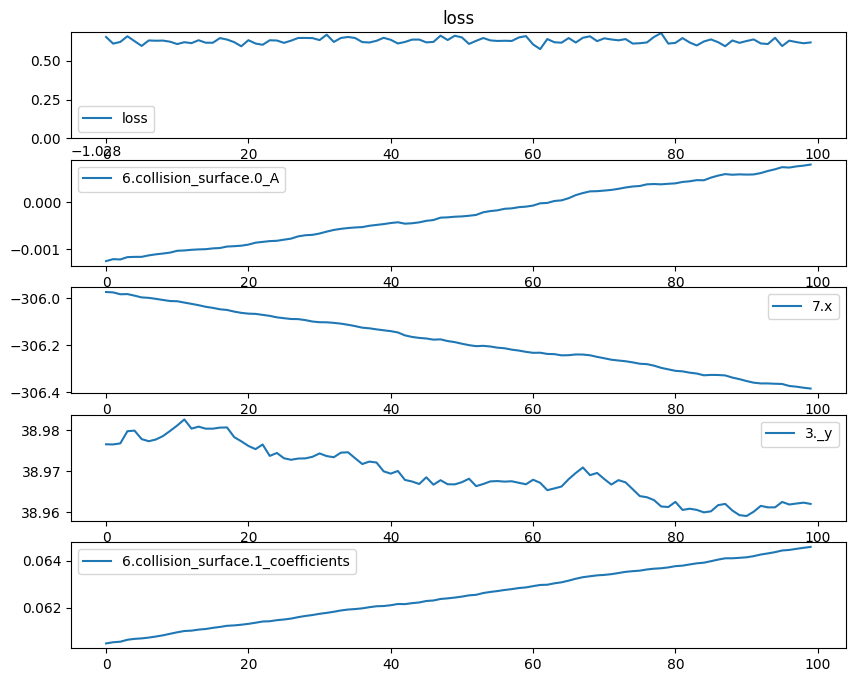

Best loss 0.5748624205589294 at iteration 62 / 100
    3._y tensor(38.9672, dtype=torch.float64)
    4.z tensor(4.3000, dtype=torch.float64)
    6.collision_surface.0_A tensor(-1.0280, dtype=torch.float64)
    6.collision_surface.1_coefficients tensor([[ 0.0000e+00, -2.4012e-04, -6.3436e-03,  2.8899e-04, -1.8975e-02],
        [ 1.0081e-02,  4.1119e-04,  3.6392e-02,  3.8965e-04,  6.2917e-03],
        [ 1.1505e-02, -3.0674e-04,  2.5081e-02,  2.8011e-04,  5.5918e-03],
        [ 1.2290e-02, -5.8703e-04,  1.3671e-02,  5.2527e-05,  3.3039e-03],
        [-1.3284e-02, -7.4026e-04,  6.0125e-03, -4.1042e-05,  1.6308e-03],
        [-1.4185e-02, -5.7600e-04,  2.1769e-03, -5.8626e-05,  7.0098e-04],
        [-1.5289e-02, -4.3186e-04,  3.9947e-04, -5.0967e-05,  2.4281e-04],
        [-1.2012e-02, -2.9363e-04, -2.6583e-04, -3.7415e-05,  4.2262e-05],
        [-9.1288e-03, -1.9624e-04, -4.4152e-04, -2.5384e-05, -3.2551e-05],
        [-6.3943e-03, -1.2695e-04, -4.1624e-04, -1.6425e-05, -5.1111e-05],
     

In [9]:
param_groups = [
    {'params': [A], 'lr': 0.0001},
    {'params': [G0], 'lr': 5},
    {'params': [T], 'lr': 1.5},
    #{'params': [R], 'lr': 30},
    {'params': [C], 'lr': 0.00010},
]


record = tlm.optimize(
    optics,
    optimizer = optim.SGD(param_groups),
    sampling = {"xx": 5000, "disable_viewer": True, "letter": "positive"},
    dim = 3,
    num_iter = 100,
    nshow=500,
)

plot_record(record, param_groups, optics)
record.best()

print()
print("Final values")
print("A", A)
print("G0", G0)
print("T", T)
print("R", R)

# Print rod position
target = rod_data.value.target()
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())

xxrender(optics, sampling={"xx": 500, "letter": "both"}, extra_artists={Primary: PrimaryArtist()}, end=200)

In [10]:
# Print rod position
target = rod_data.value.target()
print("ROD POSITION IN XX FRAME")
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())
rod_z = f"z{-target[0].item():.0f}"
print(rod_z)

def xxgridH(N):
    x = np.linspace(-1, 499, N)
    y = np.linspace(-499, 499, N)
    X, Y = np.meshgrid(x, y)
    return np.stack((X, Y), -1).reshape(-1, 2)

with torch.no_grad():
    part_primary = tess_mirror(xxgridH(150), primary_data.value.tf(), primary)

    # flip part around the Y=0 plane to make second part
    part_primary2 = tess_mirror(xxgridH(150), primary_data.value.tf(), primary, flipy=True)

part_sides = makesides(part_primary.vectors.dtype)

mesh.Mesh(np.concatenate([
    part_primary.data,
    part_primary2.data,
    part_sides.data
])).save(f"parabola6-double-{rod_z}.stl")



ROD POSITION IN XX FRAME
ROD X 0.0
ROD Y 0.0
ROD Z 306.3843612746855
z306
not in box tensor(0)
not in box tensor(0)
